In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

WORKING_DIR = 'C:/term_project/'
os.chdir(WORKING_DIR)
print(os.getcwd())

C:\term_project


In [2]:
# IMPORTS & CONFIG

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

DATA_DIR = os.path.join(WORKING_DIR, 'data')
RESULT_DIR = os.path.join(WORKING_DIR, 'results')

# Improved lag periods (focus on dengue incubation: 1-2 weeks + seasonal)
LAG_WEEKS = [1, 2, 3, 4, 8, 12, 26, 52]
ROLLING_WEEKS = [4, 8, 12, 26, 52]
EWM_SPANS = [4, 8, 12, 26]  # Exponential weighted moving averages

# Reduced oversampling (was 5, now 2)
OVERSAMPLE_THRESHOLD = 20
OVERSAMPLE_MULTIPLIER = 2

# Use only horizon t+1 for simplicity
PREDICTION_HORIZON = 1

# Feature selection
MAX_FEATURES = 50
CORRELATION_THRESHOLD = 0.95  # Remove highly correlated features

# Time series CV folds
N_SPLITS = 5

# Optuna trials
N_TRIALS = 50

In [3]:
# LOAD DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan:", sj_train_features.shape)
print("Iquitos:", iq_train_features.shape)

San Juan: (936, 21)
Iquitos: (520, 21)


In [4]:
# PREPROCESS DATA

def preprocess_city_data(features, labels=None):
    """Merge features/labels, set datetime index, fill missing values."""
    df = features.join(labels) if labels is not None else features.copy()
    df.reset_index(inplace=True)
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    df.set_index('week_start_date', inplace=True)
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    df = df.ffill()
    return df

sj_train = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan:", sj_train.shape)
print("Iquitos:", iq_train.shape)

San Juan: (936, 23)
Iquitos: (520, 23)


In [22]:
sj_train.columns

Index(['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

In [5]:
# FEATURE ENGINEERING (Improved)

def create_features(df):
    """Create enhanced features including cyclical, interactions, EWM."""
    df_eng = df.copy()
    
    # 1. CYCLICAL TIME FEATURES (sin/cos encoding)
    df_eng['week_sin'] = np.sin(2 * np.pi * df_eng['weekofyear'] / 52)
    df_eng['week_cos'] = np.cos(2 * np.pi * df_eng['weekofyear'] / 52)
    df_eng['month'] = df_eng.index.month
    df_eng['month_sin'] = np.sin(2 * np.pi * df_eng['month'] / 12)
    df_eng['month_cos'] = np.cos(2 * np.pi * df_eng['month'] / 12)
    
    # Climate feature columns
    climate_cols = [c for c in df.columns if c not in ['total_cases', 'year', 'weekofyear']]
    
    # 2. INTERACTION FEATURES (temperature × humidity, etc.)
    temp_cols = [c for c in climate_cols if 'temp' in c.lower()]
    humid_cols = [c for c in climate_cols if 'humid' in c.lower()]
    precip_cols = [c for c in climate_cols if 'precip' in c.lower()]
    
    for temp_col in temp_cols[:2]:  # Limit interactions
        for humid_col in humid_cols[:2]:
            df_eng[f'{temp_col}_x_{humid_col}'] = df_eng[temp_col] * df_eng[humid_col]
        for precip_col in precip_cols[:1]:
            df_eng[f'{temp_col}_x_{precip_col}'] = df_eng[temp_col] * df_eng[precip_col]
    
    new_features = []
    
    for col in climate_cols:
        # 4. LAG FEATURES (focused on dengue incubation 1-2 weeks)
        for lag in LAG_WEEKS:
            new_features.append(df_eng[col].shift(lag).rename(f'{col}_lag_{lag}'))
        
        # ROLLING FEATURES
        for window in ROLLING_WEEKS:
            rolling = df_eng[col].rolling(window=window)
            new_features.append(rolling.mean().rename(f'{col}_roll_mean_{window}'))
            new_features.append(rolling.std().rename(f'{col}_roll_std_{window}'))
        
        # 3. EXPONENTIAL WEIGHTED MOVING AVERAGES
        for span in EWM_SPANS:
            new_features.append(df_eng[col].ewm(span=span).mean().rename(f'{col}_ewm_{span}'))
    
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
    
    # Drop year, weekofyear (replaced by cyclical)
    df_eng.drop(columns=['year', 'weekofyear', 'month'], inplace=True, errors='ignore')
    
    df_eng.dropna(inplace=True)
    return df_eng

sj_train_eng = create_features(sj_train)
iq_train_eng = create_features(iq_train)

print("San Juan Engineered:", sj_train_eng.shape)
print("Iquitos Engineered:", iq_train_eng.shape)

San Juan Engineered: (884, 471)
Iquitos Engineered: (468, 471)


In [6]:
# 11. HANDLE OUTLIERS - Clip extreme values

def clip_outliers(df, target_col='total_cases', upper_percentile=99):
    """Clip target outliers to reduce impact of extreme values."""
    df = df.copy()
    upper_bound = df[target_col].quantile(upper_percentile / 100)
    df[target_col] = df[target_col].clip(upper=upper_bound)
    print(f"Clipped {target_col} to max {upper_bound:.0f}")
    return df

sj_train_eng = clip_outliers(sj_train_eng)
iq_train_eng = clip_outliers(iq_train_eng)

Clipped total_cases to max 330
Clipped total_cases to max 47


In [7]:
# 17. REMOVE HIGHLY CORRELATED FEATURES

def remove_correlated_features(df, target_col='total_cases', threshold=CORRELATION_THRESHOLD):
    """Remove features with correlation > threshold."""
    feature_cols = [c for c in df.columns if c != target_col]
    corr_matrix = df[feature_cols].corr().abs()
    
    # Upper triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features to drop
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    
    print(f"Removing {len(to_drop)} highly correlated features")
    df = df.drop(columns=to_drop)
    return df

sj_train_eng = remove_correlated_features(sj_train_eng)
iq_train_eng = remove_correlated_features(iq_train_eng)

print("\nAfter removing correlated features:")
print("San Juan:", sj_train_eng.shape)
print("Iquitos:", iq_train_eng.shape)

Removing 150 highly correlated features
Removing 116 highly correlated features

After removing correlated features:
San Juan: (884, 321)
Iquitos: (468, 355)


In [8]:
# FEATURE SELECTION (In-notebook, replaces loading from JSON)

def select_features(df, target_col='total_cases', max_features=MAX_FEATURES):
    """Select top features using XGBoost importance."""
    feature_cols = [c for c in df.columns if c != target_col]
    X = df[feature_cols]
    y = df[target_col]
    
    # Quick XGBoost for feature importance
    model = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
    model.fit(X, y, verbose=False)
    
    # Get importance
    importance = pd.Series(model.feature_importances_, index=feature_cols)
    importance = importance.sort_values(ascending=False)
    
    # Select top features
    selected = importance.head(max_features).index.tolist()
    print(f"Selected {len(selected)} features")
    print(f"Top 10: {selected[:10]}")
    
    return selected

print("Selecting features for San Juan...")
sj_selected = select_features(sj_train_eng)

print("\nSelecting features for Iquitos...")
iq_selected = select_features(iq_train_eng)

# Filter to selected features
sj_train_final = sj_train_eng[sj_selected + ['total_cases']]
iq_train_final = iq_train_eng[iq_selected + ['total_cases']]

Selecting features for San Juan...
Selected 50 features
Top 10: ['ndvi_nw_roll_std_4', 'ndvi_ne_roll_std_26', 'week_sin', 'station_precip_mm_roll_std_26', 'station_max_temp_c_ewm_26', 'reanalysis_dew_point_temp_k_roll_std_52', 'reanalysis_min_air_temp_k_roll_std_52', 'station_precip_mm_roll_std_52', 'station_max_temp_c_roll_mean_26', 'station_avg_temp_c_roll_std_52']

Selecting features for Iquitos...
Selected 50 features
Top 10: ['reanalysis_min_air_temp_k_ewm_26', 'station_avg_temp_c_ewm_26', 'station_max_temp_c_roll_mean_52', 'reanalysis_min_air_temp_k_roll_std_52', 'reanalysis_avg_temp_k_roll_std_8', 'station_precip_mm_roll_std_26', 'station_max_temp_c_roll_std_52', 'station_diur_temp_rng_c_roll_std_26', 'reanalysis_air_temp_k_roll_mean_26', 'reanalysis_max_air_temp_k_roll_std_26']


In [9]:
# 13. CREATE HORIZON TARGET (t+1 only for simplicity)

def create_horizon_target(df, target_col='total_cases', horizon=PREDICTION_HORIZON):
    """Create shifted target for t+n prediction."""
    df = df.copy()
    df['target'] = df[target_col].shift(-horizon)
    df = df.dropna(subset=['target'])
    return df

sj_train_final = create_horizon_target(sj_train_final)
iq_train_final = create_horizon_target(iq_train_final)

print(f"Using prediction horizon: t+{PREDICTION_HORIZON}")
print("San Juan:", sj_train_final.shape)
print("Iquitos:", iq_train_final.shape)

Using prediction horizon: t+1
San Juan: (883, 52)
Iquitos: (467, 52)


In [10]:
# 12. SAMPLE WEIGHTS (Recent samples weighted higher)

def create_sample_weights(n_samples, decay=0.995):
    """Create exponentially increasing weights for recent samples."""
    weights = np.array([decay ** (n_samples - i - 1) for i in range(n_samples)])
    weights = weights / weights.sum() * n_samples  # Normalize
    return weights

# 9. REDUCED OVERSAMPLING

def oversample_peaks(X, y, threshold=OVERSAMPLE_THRESHOLD, multiplier=OVERSAMPLE_MULTIPLIER):
    """Oversample high-case periods with reduced multiplier."""
    peak_mask = y > threshold
    if peak_mask.sum() == 0:
        return X, y
    
    X_peaks = X[peak_mask]
    y_peaks = y[peak_mask]
    
    X_list = [X]
    y_list = [y]
    for _ in range(multiplier):
        X_list.append(X_peaks)
        y_list.append(y_peaks)
    
    return pd.concat(X_list), pd.concat(y_list)

In [11]:
# 10. TIME SERIES CROSS-VALIDATION

def time_series_cv_score(model_fn, X, y, n_splits=N_SPLITS):
    """Evaluate model using time series cross-validation."""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Oversample training data
        X_train_os, y_train_os = oversample_peaks(X_train, y_train)
        
        # Sample weights
        weights = create_sample_weights(len(X_train_os))
        
        model = model_fn()
        if hasattr(model, 'fit'):
            try:
                model.fit(X_train_os, y_train_os, sample_weight=weights)
            except TypeError:
                model.fit(X_train_os, y_train_os)
        
        preds = np.maximum(model.predict(X_val), 0)
        mae = mean_absolute_error(y_val, preds)
        scores.append(mae)
    
    return np.mean(scores), np.std(scores)

In [12]:
# 8. HYPERPARAMETER TUNING WITH OPTUNA

def optimize_xgboost(X, y, n_trials=N_TRIALS):
    """Optimize XGBoost using Optuna with time series CV."""
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state': 42,
            'n_jobs': -1
        }
        
        model_fn = lambda: xgb.XGBRegressor(**params)
        mean_mae, _ = time_series_cv_score(model_fn, X, y)
        return mean_mae
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params, study.best_value


def optimize_lightgbm(X, y, n_trials=N_TRIALS):
    """Optimize LightGBM using Optuna with time series CV."""
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }
        
        model_fn = lambda: lgb.LGBMRegressor(**params)
        mean_mae, _ = time_series_cv_score(model_fn, X, y)
        return mean_mae
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params, study.best_value

In [13]:
# PREPARE DATA FOR TRAINING

def prepare_data(df, selected_features):
    """Prepare X and y from dataframe."""
    X = df[selected_features]
    y = df['target']
    return X, y

X_sj, y_sj = prepare_data(sj_train_final, sj_selected)
X_iq, y_iq = prepare_data(iq_train_final, iq_selected)

print("San Juan: X=", X_sj.shape, "y=", y_sj.shape)
print("Iquitos: X=", X_iq.shape, "y=", y_iq.shape)

San Juan: X= (883, 50) y= (883,)
Iquitos: X= (467, 50) y= (467,)


In [14]:
# TUNE SAN JUAN MODELS

print("="*60)
print("Optimizing San Juan XGBoost...")
print("="*60)
sj_xgb_params, sj_xgb_score = optimize_xgboost(X_sj, y_sj)
print(f"Best XGBoost MAE: {sj_xgb_score:.4f}")
print(f"Best params: {sj_xgb_params}")

print("\n" + "="*60)
print("Optimizing San Juan LightGBM...")
print("="*60)
sj_lgb_params, sj_lgb_score = optimize_lightgbm(X_sj, y_sj)
print(f"Best LightGBM MAE: {sj_lgb_score:.4f}")
print(f"Best params: {sj_lgb_params}")

Optimizing San Juan XGBoost...


Best trial: 33. Best value: 30.2969: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Best XGBoost MAE: 30.2969
Best params: {'max_depth': 4, 'learning_rate': 0.0687984529776677, 'n_estimators': 240, 'subsample': 0.9728420794425479, 'colsample_bytree': 0.8337936188787846, 'min_child_weight': 2, 'reg_alpha': 0.1420234036556922, 'reg_lambda': 1.022330358012728e-06}

Optimizing San Juan LightGBM...


Best trial: 15. Best value: 30.3961: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s]

Best LightGBM MAE: 30.3961
Best params: {'max_depth': 4, 'learning_rate': 0.12112983205742871, 'n_estimators': 262, 'subsample': 0.6045894546552425, 'colsample_bytree': 0.658262712056481, 'min_child_samples': 13, 'reg_alpha': 0.0005489976653328427, 'reg_lambda': 8.111155871174862}


In [15]:
# TUNE IQUITOS MODELS

print("="*60)
print("Optimizing Iquitos XGBoost...")
print("="*60)
iq_xgb_params, iq_xgb_score = optimize_xgboost(X_iq, y_iq)
print(f"Best XGBoost MAE: {iq_xgb_score:.4f}")
print(f"Best params: {iq_xgb_params}")

print("\n" + "="*60)
print("Optimizing Iquitos LightGBM...")
print("="*60)
iq_lgb_params, iq_lgb_score = optimize_lightgbm(X_iq, y_iq)
print(f"Best LightGBM MAE: {iq_lgb_score:.4f}")
print(f"Best params: {iq_lgb_params}")

Optimizing Iquitos XGBoost...


Best trial: 13. Best value: 5.92422: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Best XGBoost MAE: 5.9242
Best params: {'max_depth': 6, 'learning_rate': 0.1571868211395121, 'n_estimators': 256, 'subsample': 0.6503774746802818, 'colsample_bytree': 0.7883276957003689, 'min_child_weight': 6, 'reg_alpha': 4.3934120944609044e-07, 'reg_lambda': 0.8740929892456333}

Optimizing Iquitos LightGBM...


Best trial: 41. Best value: 6.14632: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s]

Best LightGBM MAE: 6.1463
Best params: {'max_depth': 3, 'learning_rate': 0.02958111319906701, 'n_estimators': 169, 'subsample': 0.8862632628915803, 'colsample_bytree': 0.7404233507833871, 'min_child_samples': 45, 'reg_alpha': 0.730860916677899, 'reg_lambda': 0.21280644601428433}


In [16]:
# 5. ENSEMBLE MODELS

def train_ensemble(X, y, xgb_params, lgb_params):
    """Train ensemble of XGBoost, LightGBM, and RandomForest."""
    # Oversample and get weights
    X_os, y_os = oversample_peaks(X, y)
    weights = create_sample_weights(len(X_os))
    
    # XGBoost
    xgb_model = xgb.XGBRegressor(**xgb_params, random_state=42, n_jobs=-1)
    xgb_model.fit(X_os, y_os, sample_weight=weights)
    
    # LightGBM
    lgb_model = lgb.LGBMRegressor(**lgb_params, random_state=42, n_jobs=-1, verbose=-1)
    lgb_model.fit(X_os, y_os, sample_weight=weights)
    
    # RandomForest
    rf_model = RandomForestRegressor(
        n_estimators=200, max_depth=8, min_samples_leaf=5,
        random_state=42, n_jobs=-1
    )
    rf_model.fit(X_os, y_os, sample_weight=weights)
    
    return {'xgb': xgb_model, 'lgb': lgb_model, 'rf': rf_model}


def ensemble_predict(models, X, weights={'xgb': 0.4, 'lgb': 0.4, 'rf': 0.2}):
    """Weighted average ensemble prediction."""
    preds = np.zeros(len(X))
    for name, model in models.items():
        preds += weights[name] * model.predict(X)
    return np.maximum(preds, 0)


print("Training San Juan Ensemble...")
sj_models = train_ensemble(X_sj, y_sj, sj_xgb_params, sj_lgb_params)

print("Training Iquitos Ensemble...")
iq_models = train_ensemble(X_iq, y_iq, iq_xgb_params, iq_lgb_params)

print("\nEnsemble training complete!")

Training San Juan Ensemble...
Training Iquitos Ensemble...

Ensemble training complete!


San Juan Training MAE: 6.2616
Iquitos Training MAE: 1.7270


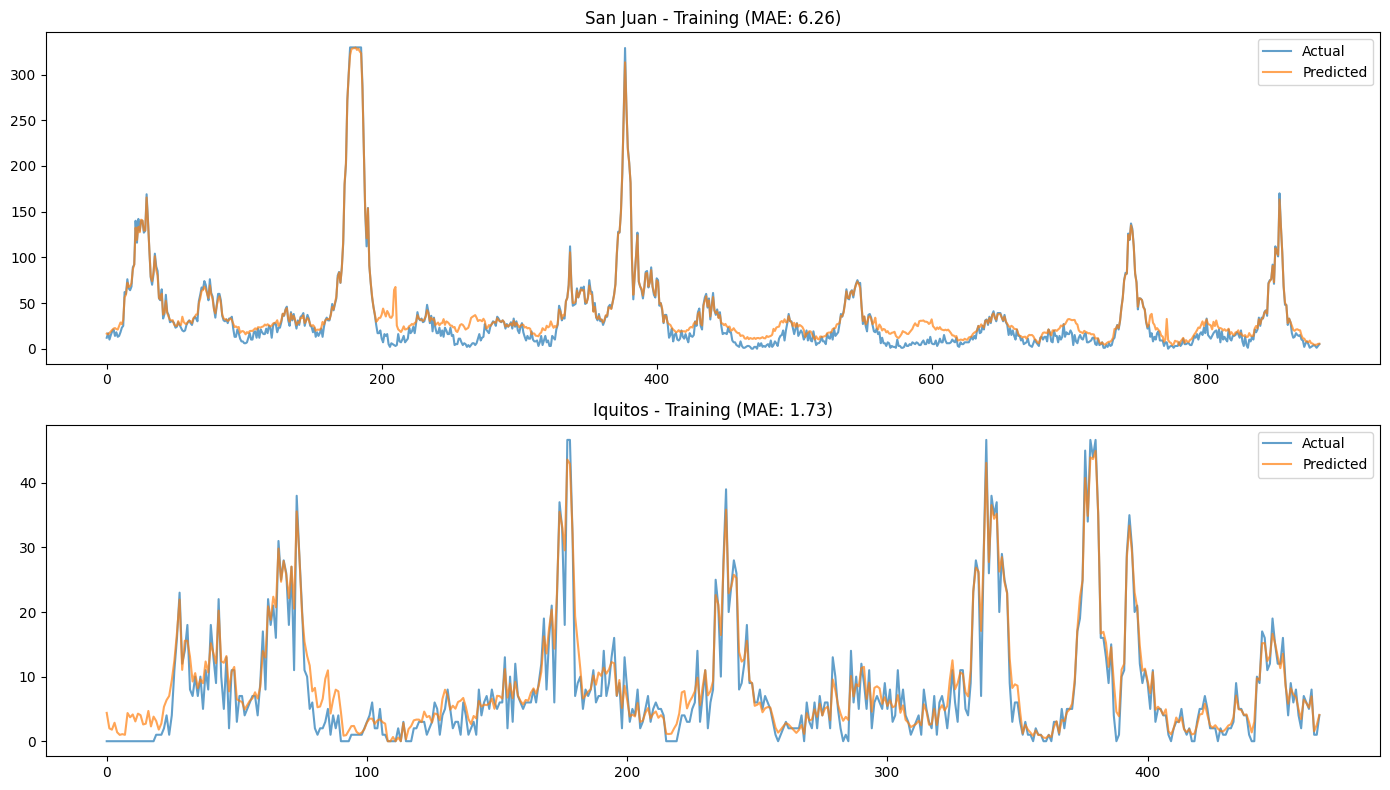

In [17]:
# EVALUATE ON TRAINING DATA

sj_train_preds = ensemble_predict(sj_models, X_sj)
sj_train_mae = mean_absolute_error(y_sj, sj_train_preds)
print(f"San Juan Training MAE: {sj_train_mae:.4f}")

iq_train_preds = ensemble_predict(iq_models, X_iq)
iq_train_mae = mean_absolute_error(y_iq, iq_train_preds)
print(f"Iquitos Training MAE: {iq_train_mae:.4f}")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(y_sj.values, label='Actual', alpha=0.7)
axes[0].plot(sj_train_preds, label='Predicted', alpha=0.7)
axes[0].set_title(f'San Juan - Training (MAE: {sj_train_mae:.2f})')
axes[0].legend()

axes[1].plot(y_iq.values, label='Actual', alpha=0.7)
axes[1].plot(iq_train_preds, label='Predicted', alpha=0.7)
axes[1].set_title(f'Iquitos - Training (MAE: {iq_train_mae:.2f})')
axes[1].legend()

plt.tight_layout()
plt.show()

In [18]:
# PREPARE TEST FEATURES

def prepare_test_features(train_df, test_df, selected_features):
    """Combine train tail with test to generate features."""
    max_lookback = max(LAG_WEEKS + ROLLING_WEEKS + EWM_SPANS) + 10
    
    # Get train subset (matching test columns)
    common_cols = [c for c in train_df.columns if c in test_df.columns]
    train_subset = train_df[common_cols].tail(max_lookback)
    
    # Combine
    combined = pd.concat([train_subset, test_df])
    
    # Create features
    combined_eng = create_features(combined)
    
    # Get test portion
    test_eng = combined_eng.loc[test_df.index]
    
    # Select features (handle missing)
    available = [f for f in selected_features if f in test_eng.columns]
    return test_eng[available]


# Load test data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])

sj_test = preprocess_city_data(test_features.loc['sj'])
iq_test = preprocess_city_data(test_features.loc['iq'])

print("Preparing test features...")
X_test_sj = prepare_test_features(sj_train, sj_test, sj_selected)
X_test_iq = prepare_test_features(iq_train, iq_test, iq_selected)

print(f"San Juan Test: {X_test_sj.shape}")
print(f"Iquitos Test: {X_test_iq.shape}")

Preparing test features...
San Juan Test: (260, 50)
Iquitos Test: (156, 50)


In [19]:
# GENERATE PREDICTIONS

# Ensure columns match
sj_common_cols = [c for c in sj_selected if c in X_test_sj.columns]
iq_common_cols = [c for c in iq_selected if c in X_test_iq.columns]

# Retrain on common columns if needed
if len(sj_common_cols) < len(sj_selected):
    print(f"Warning: San Juan missing {len(sj_selected) - len(sj_common_cols)} features in test")
    X_sj_common = X_sj[sj_common_cols]
    sj_models = train_ensemble(X_sj_common, y_sj, sj_xgb_params, sj_lgb_params)

if len(iq_common_cols) < len(iq_selected):
    print(f"Warning: Iquitos missing {len(iq_selected) - len(iq_common_cols)} features in test")
    X_iq_common = X_iq[iq_common_cols]
    iq_models = train_ensemble(X_iq_common, y_iq, iq_xgb_params, iq_lgb_params)

# Predict
sj_preds = ensemble_predict(sj_models, X_test_sj[sj_common_cols]).astype(int)
iq_preds = ensemble_predict(iq_models, X_test_iq[iq_common_cols]).astype(int)

print(f"San Juan: {len(sj_preds)} predictions")
print(f"Iquitos: {len(iq_preds)} predictions")

San Juan: 260 predictions
Iquitos: 156 predictions


In [20]:
# CREATE SUBMISSION

submission = pd.read_csv(os.path.join(DATA_DIR, 'submission_format.csv'), index_col=[0, 1, 2])

submission.loc['sj', 'total_cases'] = sj_preds
submission.loc['iq', 'total_cases'] = iq_preds

# Save
submission_path = os.path.join(RESULT_DIR, 'submission_xgboost_improved.csv')
submission.to_csv(submission_path)

print(f"Submission saved to {submission_path}")
print("\nImprovements applied:")
print("  1. Cyclical time features (sin/cos)")
print("  2. Interaction features (temp × humidity)")
print("  3. Exponential weighted moving averages")
print("  4. Focused lag periods (dengue incubation)")
print("  5. Ensemble (XGBoost + LightGBM + RF)")
print("  8. Optuna hyperparameter tuning")
print("  9. Reduced oversampling (2x vs 5x)")
print("  10. Time series cross-validation")
print("  11. Outlier clipping")
print("  12. Recency-weighted samples")
print("  13. Single horizon (t+1)")
print("  17. Removed correlated features")

submission.head(10)

Submission saved to C:/term_project/results\submission_xgboost_improved.csv

Improvements applied:
  1. Cyclical time features (sin/cos)
  2. Interaction features (temp × humidity)
  3. Exponential weighted moving averages
  4. Focused lag periods (dengue incubation)
  5. Ensemble (XGBoost + LightGBM + RF)
  8. Optuna hyperparameter tuning
  9. Reduced oversampling (2x vs 5x)
  10. Time series cross-validation
  11. Outlier clipping
  12. Recency-weighted samples
  13. Single horizon (t+1)
  17. Removed correlated features


total_cases
city year weekofyear             
sj   2008 18                    5
          19                    6
          20                    8
          21                   12
          22                   10
          23                   11
          24                   12
          25                   12
          26                   13
          27                   17

In [ ]:
# SUBMISSION SCORE: 